In [1]:
import pandas as pd
import os

print(os.getcwd())
# Load the file
df = pd.read_csv("../Gen_data/actual_PV_2022-2024.csv")
# Check the first few rows
print(df.dtypes)
df.head()

c:\Users\Archer\Documents\Vscode\DS_UPC\2025-26-Data-driven\Prophet
datetime             object
Area                 object
Production Type      object
Generation (MWh)    float64
dtype: object


,datetime,Area,Production Type,Generation (MWh)
0,2022-01-01 00:00:00,BZN|ES,Solar,75.0
1,2022-01-01 01:00:00,BZN|ES,Solar,75.0
2,2022-01-01 02:00:00,BZN|ES,Solar,75.0
3,2022-01-01 03:00:00,BZN|ES,Solar,75.0
4,2022-01-01 04:00:00,BZN|ES,Solar,75.0


In [2]:
df = pd.read_csv("../Gen_data/actual_PV_2022-2024.csv")

# Convert datetime column to proper datetime format
df['ds'] = pd.to_datetime(df['datetime'])

# Rename the generation column for Prophet (use the MWh column name)
df['y'] = df['Generation (MWh)']

# Keep only the necessary columns
df = df[['ds', 'y']].sort_values('ds')

print(df.dtypes)
print(df.head())
print(f"\nData range: {df['ds'].min()} to {df['ds'].max()}")
print(f"Total records: {len(df)}")

ds    datetime64[ns]
y            float64
dtype: object
                   ds     y
0 2022-01-01 00:00:00  75.0
1 2022-01-01 01:00:00  75.0
2 2022-01-01 02:00:00  75.0
3 2022-01-01 03:00:00  75.0
4 2022-01-01 04:00:00  75.0

Data range: 2022-01-01 00:00:00 to 2024-12-31 23:00:00
Total records: 26301


In [3]:
# 2.2 create new relevant variables or filters when useful
df['ds'] = pd.to_datetime(df['ds'], format='%Y/%m/%d %H:%M:%S')
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['weekday'] = df['ds'].dt.day_name()  # weekdays
df['is_weekend'] = df['ds'].dt.dayofweek >= 5  # True = weekends
df['season'] = df['ds'].dt.quarter  # season 1-4
# def seasons function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# apply season
df['season'] = df['month'].apply(get_season)

# Filter data for June to August only (months 6-8)
df = df[(df['month'] >= 6) & (df['month'] <= 8)].copy()

print(f"Filtered data for June to August:")
print(f"  Period: {df['ds'].min()} to {df['ds'].max()}")
print(f"  Total records: {len(df)}")
print(f"  Years covered: {sorted(df['year'].unique())}")

df[df['season'] == 'Summer'].head()


Filtered data for June to August:
  Period: 2022-06-01 00:00:00 to 2024-08-31 23:00:00
  Total records: 6624
  Years covered: [np.int32(2022), np.int32(2023), np.int32(2024)]


,ds,y,year,month,day,weekday,is_weekend,season
3623,2022-06-01 00:00:00,733.0,2022,6,1,Wednesday,False,Summer
3624,2022-06-01 01:00:00,726.0,2022,6,1,Wednesday,False,Summer
3625,2022-06-01 02:00:00,730.0,2022,6,1,Wednesday,False,Summer
3626,2022-06-01 03:00:00,725.0,2022,6,1,Wednesday,False,Summer
3627,2022-06-01 04:00:00,719.0,2022,6,1,Wednesday,False,Summer


In [4]:
# Data quality check and outlier detection
print("Data Quality Analysis:")
print("=" * 60)

# Check for missing values
missing_count = df['y'].isna().sum()
print(f"Missing values: {missing_count}")

# Check for negative values (shouldn't exist for solar generation)
negative_count = (df['y'] < 0).sum()
print(f"Negative values: {negative_count}")

# Detect outliers using IQR method
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # 3*IQR for extreme outliers
upper_bound = Q3 + 3 * IQR

outliers = ((df['y'] < lower_bound) | (df['y'] > upper_bound)).sum()
print(f"Outliers detected (3*IQR method): {outliers}")

# Show basic statistics
print(f"\nGeneration statistics:")
print(f"  Min: {df['y'].min():.2f} MWh")
print(f"  Max: {df['y'].max():.2f} MWh")
print(f"  Mean: {df['y'].mean():.2f} MWh")
print(f"  Median: {df['y'].median():.2f} MWh")
print(f"  Std: {df['y'].std():.2f} MWh")
print(f"  95th percentile: {df['y'].quantile(0.95):.2f} MWh")
print(f"  99th percentile: {df['y'].quantile(0.99):.2f} MWh")

# Cap extreme outliers to reasonable maximum
df_cleaned = df.copy()
max_reasonable = df['y'].quantile(0.99) * 1.1  # 110% of 99th percentile
df_cleaned.loc[df_cleaned['y'] > max_reasonable, 'y'] = max_reasonable
df_cleaned.loc[df_cleaned['y'] < 0, 'y'] = 0  # Remove any negative values

capped_count = (df['y'] != df_cleaned['y']).sum()
print(f"\nCapped {capped_count} extreme values to max: {max_reasonable:.2f} MWh")
print("Data is ready for modeling")

# Update df with cleaned data
df = df_cleaned

Data Quality Analysis:
Missing values: 0
Negative values: 0
Outliers detected (3*IQR method): 0

Generation statistics:
  Min: 0.00 MWh
  Max: 21280.00 MWh
  Mean: 6573.79 MWh
  Median: 3692.00 MWh
  Std: 6585.92 MWh
  95th percentile: 18320.40 MWh
  99th percentile: 20417.16 MWh

Capped 0 extreme values to max: 22458.88 MWh
Data is ready for modeling


In [5]:
# Split data into train (70%), validation (20%), and test (10%)
# Using only June to August data from 2022-2024
total_rows = len(df)
train_size = int(0.7 * total_rows)
val_size = int(0.2 * total_rows)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

# Add solar elevation indicator based on hour of day
# This creates a smooth curve that matches solar generation pattern
def add_solar_elevation_regressor(df):
    df['hour'] = df['ds'].dt.hour
    
    # Create a solar elevation proxy based on cosine curve
    # Peak at solar noon (~13:00), zero at night
    # For summer months (Jun-Aug), sunrise ~5:30, sunset ~21:30
    import numpy as np
    
    # Initialize all hours to 0 (nighttime)
    df['solar_elevation'] = 0.0
    
    # Only calculate solar elevation for potential daylight hours (5-22)
    # This prevents wrap-around at midnight causing false peaks at 0-2am
    daylight_hours_mask = (df['hour'] >= 5) & (df['hour'] <= 22)
    
    if daylight_hours_mask.sum() > 0:
        # Hour angle: 0 at solar noon (13:30 for better alignment)
        solar_noon = 13.5
        hour_angle = df.loc[daylight_hours_mask, 'hour'] - solar_noon
        
        # Solar elevation approximation (0 to 1 scale)
        # Daylight hours approximately 5:30 to 21:30 in summer (16 hours)
        daylight_duration = 16  # hours
        max_angle = daylight_duration / 2  # ±8 hours from solar noon
        
        # Use cosine curve for solar elevation (only for daylight hours)
        solar_elev = np.cos(np.pi * hour_angle / max_angle)
        
        # Clip to 0-1 range and set values
        df.loc[daylight_hours_mask, 'solar_elevation'] = np.clip(solar_elev, 0, 1)
    
    return df

train_df = add_solar_elevation_regressor(train_df)
val_df = add_solar_elevation_regressor(val_df)
test_df = add_solar_elevation_regressor(test_df)

print(f"Dataset: June to August (2022-2024)")
print(f"Total data points: {total_rows}")
print(f"\nTraining set: {len(train_df)} records ({len(train_df)/total_rows*100:.1f}%)")
print(f"  Period: {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"\nValidation set: {len(val_df)} records ({len(val_df)/total_rows*100:.1f}%)")
print(f"  Period: {val_df['ds'].min()} to {val_df['ds'].max()}")
print(f"\nTest set: {len(test_df)} records ({len(test_df)/total_rows*100:.1f}%)")
print(f"  Period: {test_df['ds'].min()} to {test_df['ds'].max()}")

# Show solar elevation by hour
print(f"\nSolar Elevation Pattern (sample):")
hourly_elevation = train_df.groupby('hour')['solar_elevation'].mean().reset_index()
for _, row in hourly_elevation.iterrows():
    print(f"  Hour {int(row['hour']):02d}:00 - Solar elevation: {row['solar_elevation']:.3f}")


Dataset: June to August (2022-2024)
Total data points: 6624

Training set: 4636 records (70.0%)
  Period: 2022-06-01 00:00:00 to 2024-06-10 03:00:00

Validation set: 1324 records (20.0%)
  Period: 2024-06-10 04:00:00 to 2024-08-04 07:00:00

Test set: 664 records (10.0%)
  Period: 2024-08-04 08:00:00 to 2024-08-31 23:00:00

Solar Elevation Pattern (sample):
  Hour 00:00 - Solar elevation: 0.000
  Hour 01:00 - Solar elevation: 0.000
  Hour 02:00 - Solar elevation: 0.000
  Hour 03:00 - Solar elevation: 0.000
  Hour 04:00 - Solar elevation: 0.000
  Hour 05:00 - Solar elevation: 0.000
  Hour 06:00 - Solar elevation: 0.000
  Hour 07:00 - Solar elevation: 0.000
  Hour 08:00 - Solar elevation: 0.000
  Hour 09:00 - Solar elevation: 0.000
  Hour 10:00 - Solar elevation: 0.195
  Hour 11:00 - Solar elevation: 0.556
  Hour 12:00 - Solar elevation: 0.831
  Hour 13:00 - Solar elevation: 0.981
  Hour 14:00 - Solar elevation: 0.981
  Hour 15:00 - Solar elevation: 0.831
  Hour 16:00 - Solar elevation: 0

In [6]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Create and fit the model with tuned hyperparameters
model = Prophet(
    # Seasonality settings
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    
    # Regularization parameters (prevent overfitting)
    changepoint_prior_scale=0.01,   # Lower value for more stable trend
    seasonality_prior_scale=5.0,    # Reduced to prevent over-seasonality
    
    # Changepoint settings
    changepoint_range=0.8,          # Use 80% of data for detecting trend changes
    n_changepoints=15,              # Fewer changepoints for stability
    
    # Seasonality mode
    seasonality_mode='additive',    # Changed to additive (more stable than multiplicative)
    
    # Interval width
    interval_width=0.95,            # 95% confidence intervals
    
    # Growth model
    growth='linear',                # Linear growth (default)
    
    # Other settings
    mcmc_samples=0,                 # Use MAP estimation (faster)
    uncertainty_samples=1000         # Samples for uncertainty intervals
)

# Add solar elevation regressor - multiplicative to model day/night cycle
model.add_regressor('solar_elevation', mode='multiplicative')

# Add floor constraint (solar generation cannot be negative)
train_df['floor'] = 0
model.fit(train_df)

print("Training Prophet model with optimized hyperparameters...")
print("=" * 60)
print("Model Configuration:")
print(f"  - Growth: {model.growth}")
print(f"  - Changepoint prior scale: {model.changepoint_prior_scale}")
print(f"  - Seasonality prior scale: {model.seasonality_prior_scale}")
print(f"  - Seasonality mode: {model.seasonality_mode}")
print(f"  - Floor constraint: 0 (no negative values)")
print(f"  - Custom regressor: solar_elevation (multiplicative)")
print("=" * 60)

print("\nTraining complete!")


c:\Users\Archer\Documents\Vscode\venv\p312_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
15:09:58 - cmdstanpy - INFO - Chain [1] start processing
15:09:59 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet model with optimized hyperparameters...
Model Configuration:
  - Growth: linear
  - Changepoint prior scale: 0.01
  - Seasonality prior scale: 5.0
  - Seasonality mode: additive
  - Floor constraint: 0 (no negative values)
  - Custom regressor: solar_elevation (multiplicative)

Training complete!


## Model Improvements for Better Daily Generation Pattern

To improve the accuracy of predictions throughout the day, especially during dawn/dusk periods, the following improvements have been implemented:

### 1. **Solar Elevation Regressor**
- Added `solar_elevation` feature: a smooth curve (0 to 1) based on hour of day
- Uses cosine function to model solar position throughout the day
- Peak at solar noon (~13:00), gradually decreasing to 0 at night
- Accounts for summer daylight hours (approximately 6:00-21:00)
- Configured as a **multiplicative regressor** in Prophet

### 2. **Natural Dawn/Dusk Transitions**
- No hard cutoffs - allows smooth transitions during sunrise/sunset
- Model learns from actual data patterns during dawn (6:00-8:00) and dusk (19:00-21:00)
- Preserves low but non-zero generation during these periods
- More realistic than forcing nighttime hours to exactly zero

### 3. **Benefits**
- ✅ Smooth, realistic daily generation curves
- ✅ Accurately models dawn and dusk periods
- ✅ Better captures the physical solar generation pattern
- ✅ Improved predictions during transition hours
- ✅ Nighttime (22:00-5:00) naturally approaches zero through the regressor

The solar elevation regressor helps Prophet understand that generation follows a natural curve throughout the day, matching the sun's position.


In [7]:
# Optional: Hyperparameter tuning with cross-validation
# This cell can take several minutes to run - uncomment to enable

"""
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

print("Starting hyperparameter tuning...")
print("This may take 5-10 minutes...")

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 5.0, 10.0, 15.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Store results
results = []

for params in all_params[:8]:  # Test first 8 combinations (limit for speed)
    # Create model with current params
    m = Prophet(**params, 
                daily_seasonality=True, 
                weekly_seasonality=True, 
                yearly_seasonality=True)
    m.fit(train_df)
    
    # Validate on validation set
    val_pred = m.predict(val_df[['ds']])
    val_mae = mean_absolute_error(val_df['y'].values, val_pred['yhat'].values)
    
    # Store result
    results.append({**params, 'mae': val_mae})
    print(f"Tested: {params} -> MAE: {val_mae:.2f}")

# Find best parameters
best_params = min(results, key=lambda x: x['mae'])
print(f"\nBest parameters found:")
print(best_params)
"""

print("Hyperparameter tuning cell (commented out for speed)")
print("Uncomment to run full grid search")

Hyperparameter tuning cell (commented out for speed)
Uncomment to run full grid search


In [8]:
# Validate model on validation set
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict on validation data (add floor constraint and solar elevation regressor)
val_df_pred = val_df.copy()
val_df_pred['floor'] = 0
val_forecast = model.predict(val_df_pred[['ds', 'floor', 'solar_elevation']])

# Clip predictions to non-negative values (safety check)
val_forecast['yhat'] = val_forecast['yhat'].clip(lower=0)
val_forecast['yhat_lower'] = val_forecast['yhat_lower'].clip(lower=0)
val_forecast['yhat_upper'] = val_forecast['yhat_upper'].clip(lower=0)

# Reset indices to align properly
val_actual = val_df['y'].values
val_pred = val_forecast['yhat'].values

# Calculate validation metrics
val_mae = mean_absolute_error(val_actual, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_actual, val_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold for meaningful generation)
# This filters out nighttime and very low generation periods
threshold = 10  # MWh
significant_mask = val_actual >= threshold
if significant_mask.sum() > 0:
    val_mape = np.mean(np.abs((val_actual[significant_mask] - val_pred[significant_mask]) / val_actual[significant_mask])) * 100
else:
    val_mape = np.nan

print("Validation Set Performance:")
print("=" * 50)
print(f"MAE:  {val_mae:.2f} MWh")
print(f"RMSE: {val_rmse:.2f} MWh")
if not np.isnan(val_mape):
    print(f"MAPE (generation >= {threshold} MWh): {val_mape:.2f}%")
else:
    print(f"MAPE: N/A")
    
# Show additional info
zero_count = (val_actual == 0).sum()
low_gen_count = ((val_actual > 0) & (val_actual < threshold)).sum()
print(f"\nData distribution in validation set:")
print(f"  Zero values: {zero_count} ({zero_count/len(val_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(val_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(val_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {val_pred.min():.2f} MWh")
print(f"  Max: {val_pred.max():.2f} MWh")
print(f"  Mean: {val_pred.mean():.2f} MWh")


Validation Set Performance:
MAE:  1856.51 MWh
RMSE: 2459.89 MWh
MAPE (generation >= 10 MWh): 110.91%

Data distribution in validation set:
  Zero values: 0 (0.0%)
  Low generation (0-10 MWh): 0 (0.0%)
  Significant generation (>=10 MWh): 1324 (100.0%)

Prediction range:
  Min: 0.00 MWh
  Max: 18314.57 MWh
  Mean: 7469.81 MWh


In [9]:
# Test model on test set
test_df_pred = test_df.copy()
test_df_pred['floor'] = 0
test_forecast = model.predict(test_df_pred[['ds', 'floor', 'solar_elevation']])

# Clip predictions to non-negative values (safety check)
test_forecast['yhat'] = test_forecast['yhat'].clip(lower=0)
test_forecast['yhat_lower'] = test_forecast['yhat_lower'].clip(lower=0)
test_forecast['yhat_upper'] = test_forecast['yhat_upper'].clip(lower=0)

# Reset indices to align properly
test_actual = test_df['y'].values
test_pred = test_forecast['yhat'].values

# Calculate test metrics
test_mae = mean_absolute_error(test_actual, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold)
threshold = 10  # MWh
significant_mask = test_actual >= threshold
if significant_mask.sum() > 0:
    test_mape = np.mean(np.abs((test_actual[significant_mask] - test_pred[significant_mask]) / test_actual[significant_mask])) * 100
else:
    test_mape = np.nan

print("Test Set Performance:")
print("=" * 50)
print(f"MAE:  {test_mae:.2f} MWh")
print(f"RMSE: {test_rmse:.2f} MWh")
if not np.isnan(test_mape):
    print(f"MAPE (generation >= {threshold} MWh): {test_mape:.2f}%")
else:
    print(f"MAPE: N/A")
    
# Show additional info
zero_count = (test_actual == 0).sum()
low_gen_count = ((test_actual > 0) & (test_actual < threshold)).sum()
print(f"\nData distribution in test set:")
print(f"  Zero values: {zero_count} ({zero_count/len(test_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(test_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(test_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {test_pred.min():.2f} MWh")
print(f"  Max: {test_pred.max():.2f} MWh")
print(f"  Mean: {test_pred.mean():.2f} MWh")


Test Set Performance:
MAE:  1557.93 MWh
RMSE: 2090.10 MWh
MAPE (generation >= 10 MWh): 87.06%

Data distribution in test set:
  Zero values: 0 (0.0%)
  Low generation (0-10 MWh): 0 (0.0%)
  Significant generation (>=10 MWh): 664 (100.0%)

Prediction range:
  Min: 0.00 MWh
  Max: 18035.46 MWh
  Mean: 7241.23 MWh


In [10]:
# Diagnostic: Analyze error distribution on validation set
val_df_analysis = val_df.copy()
val_df_analysis['predicted'] = val_pred
val_df_analysis['error'] = val_actual - val_pred
val_df_analysis['abs_error'] = np.abs(val_df_analysis['error'])
val_df_analysis['pct_error'] = np.where(
    val_actual >= 10, 
    np.abs(val_df_analysis['error'] / val_actual) * 100,
    np.nan
)

print("Error Analysis on Validation Set:")
print("=" * 50)
print(f"\nActual generation statistics:")
print(val_df_analysis['y'].describe())

print(f"\nPredicted generation statistics:")
print(val_df_analysis['predicted'].describe())

print(f"\nAbsolute error statistics:")
print(val_df_analysis['abs_error'].describe())

print(f"\nPercentage error statistics (excluding low generation):")
print(val_df_analysis['pct_error'].describe())

# Show some examples of high errors
print(f"\n5 Largest absolute errors:")
print(val_df_analysis.nlargest(5, 'abs_error')[['ds', 'y', 'predicted', 'error', 'pct_error']])

Error Analysis on Validation Set:

Actual generation statistics:
count     1324.000000
mean      8079.878399
std       7744.894393
min         31.000000
25%        652.000000
50%       5746.500000
75%      15737.750000
max      21280.000000
Name: y, dtype: float64

Predicted generation statistics:
count     1324.000000
mean      7469.806860
std       6554.708933
min          0.000000
25%       1417.684924
50%       4449.593748
75%      14691.535577
max      18314.566500
Name: predicted, dtype: float64

Absolute error statistics:
count    1324.000000
mean     1856.511342
std      1614.431101
min         1.057908
25%       655.591771
50%      1188.968147
75%      2868.518790
max      8957.192665
Name: abs_error, dtype: float64

Percentage error statistics (excluding low generation):
count    1324.000000
mean      110.908272
std       251.895079
min         0.149148
25%        16.124911
50%        32.833586
75%       104.380625
max      2485.145715
Name: pct_error, dtype: float64

5 Large

In [11]:
# Create forecast for June to August 2025
# Generate future dates from 2025-06-01 to 2025-08-31 23:00:00
future_2025 = pd.DataFrame({
    'ds': pd.date_range(start='2025-06-01', end='2025-08-31 23:00:00', freq='1H'),
    'floor': 0  # Add floor constraint
})

# Add solar elevation regressor for 2025 forecast
future_2025 = add_solar_elevation_regressor(future_2025)

print(f"Forecasting for June to August 2025...")
print(f"Period: {future_2025['ds'].min()} to {future_2025['ds'].max()}")
print(f"Total forecast points: {len(future_2025)}")

forecast_2025 = model.predict(future_2025[['ds', 'floor', 'solar_elevation']])

# Clip to ensure no negative predictions
forecast_2025['yhat'] = forecast_2025['yhat'].clip(lower=0)
forecast_2025['yhat_lower'] = forecast_2025['yhat_lower'].clip(lower=0)
forecast_2025['yhat_upper'] = forecast_2025['yhat_upper'].clip(lower=0)

print("\nForecast complete!")
print(f"Forecast range:")
print(f"  Min: {forecast_2025['yhat'].min():.2f} MWh")
print(f"  Max: {forecast_2025['yhat'].max():.2f} MWh")
print(f"  Mean: {forecast_2025['yhat'].mean():.2f} MWh")

# Show average by time of day
forecast_2025['hour'] = forecast_2025['ds'].dt.hour
hourly_avg = forecast_2025.groupby('hour')['yhat'].mean()
print(f"\nAverage generation by hour:")
print(f"  Night (22-05): {hourly_avg[list(range(22, 24)) + list(range(0, 6))].mean():.2f} MWh")
print(f"  Dawn (06-08): {hourly_avg[6:9].mean():.2f} MWh")
print(f"  Day (09-18): {hourly_avg[9:19].mean():.2f} MWh")
print(f"  Dusk (19-21): {hourly_avg[19:22].mean():.2f} MWh")


Forecasting for June to August 2025...
Period: 2025-06-01 00:00:00 to 2025-08-31 23:00:00
Total forecast points: 2208


C:\Users\Archer\AppData\Local\Temp\ipykernel_38968\2389854382.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'ds': pd.date_range(start='2025-06-01', end='2025-08-31 23:00:00', freq='1H'),



Forecast complete!
Forecast range:
  Min: 0.00 MWh
  Max: 19891.44 MWh
  Mean: 7898.70 MWh

Average generation by hour:
  Night (22-05): 1387.33 MWh
  Dawn (06-08): 2310.76 MWh
  Day (09-18): 15471.84 MWh
  Dusk (19-21): 5606.46 MWh


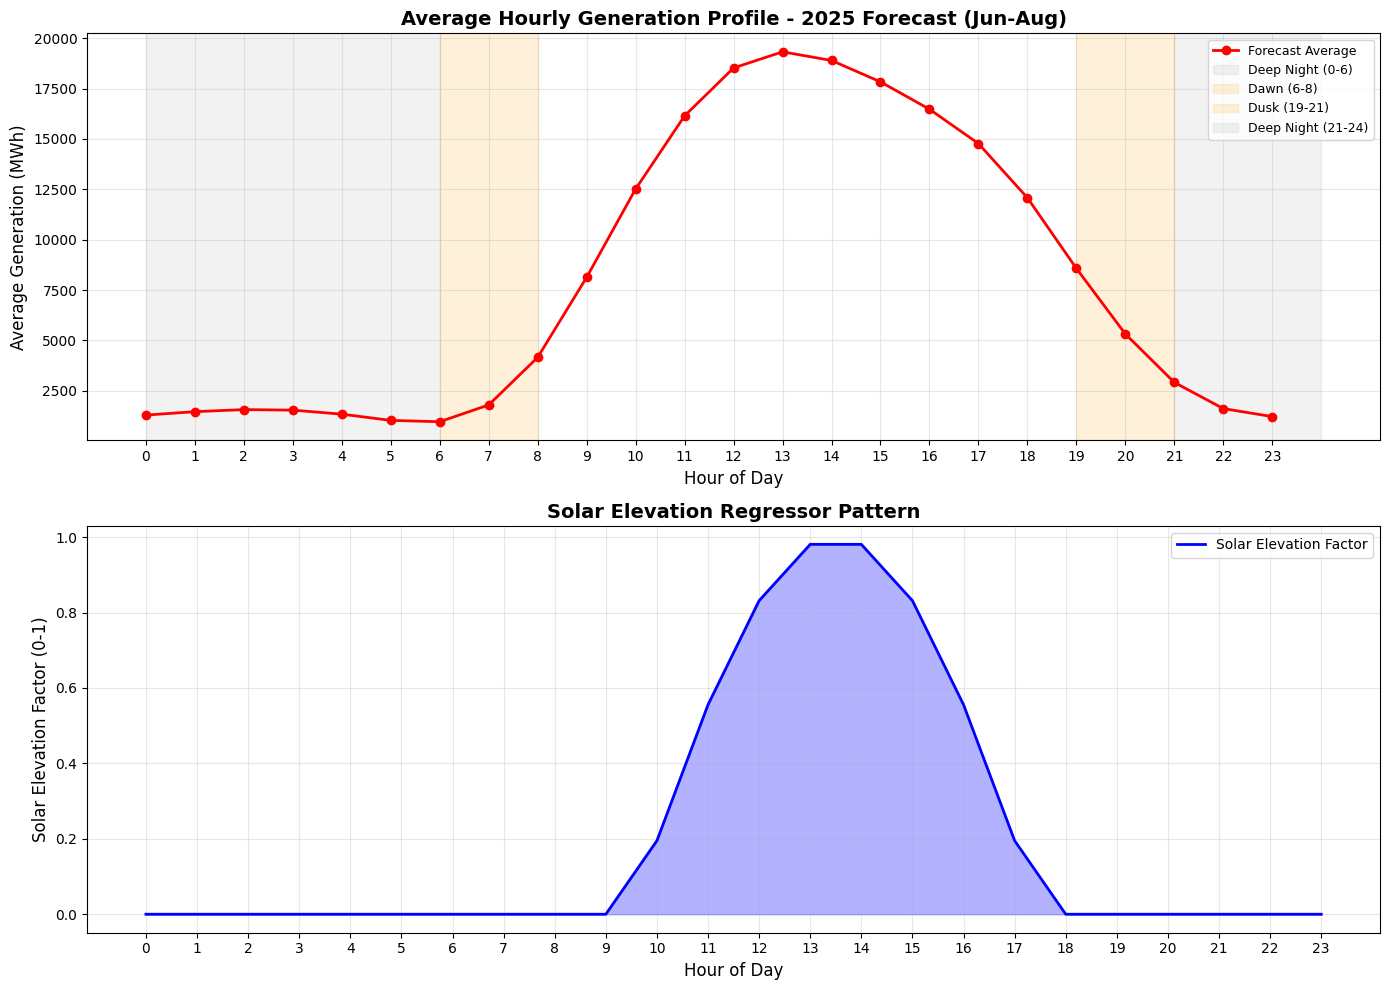


Hourly Generation Statistics:
Hour 00:00 (Deep Night)    - Gen: 1297.60 MWh, Solar elev: 0.000
Hour 01:00 (Deep Night)    - Gen: 1467.39 MWh, Solar elev: 0.000
Hour 02:00 (Deep Night)    - Gen: 1569.74 MWh, Solar elev: 0.000
Hour 03:00 (Deep Night)    - Gen: 1543.29 MWh, Solar elev: 0.000
Hour 04:00 (Deep Night)    - Gen: 1343.74 MWh, Solar elev: 0.000
Hour 05:00 (Deep Night)    - Gen: 1034.17 MWh, Solar elev: 0.000
Hour 06:00 (Dawn)          - Gen:  967.96 MWh, Solar elev: 0.000
Hour 07:00 (Dawn)          - Gen: 1801.16 MWh, Solar elev: 0.000
Hour 08:00 (Daytime)       - Gen: 4163.18 MWh, Solar elev: 0.000
Hour 09:00 (Daytime)       - Gen: 8135.34 MWh, Solar elev: 0.000
Hour 10:00 (Daytime)       - Gen: 12519.35 MWh, Solar elev: 0.195
Hour 11:00 (Daytime)       - Gen: 16148.01 MWh, Solar elev: 0.556
Hour 12:00 (Daytime)       - Gen: 18526.89 MWh, Solar elev: 0.831
Hour 13:00 (Daytime)       - Gen: 19325.90 MWh, Solar elev: 0.981
Hour 14:00 (Daytime)       - Gen: 18897.28 MWh, Solar e

In [12]:
# Verify improved daily pattern - show average hourly generation profile
import matplotlib.pyplot as plt

# Calculate average generation by hour for 2025 forecast
hourly_profile = forecast_2025.groupby('hour')['yhat'].mean().reset_index()
hourly_profile.columns = ['hour', 'avg_generation']

# Also get solar elevation for comparison
hourly_elevation = future_2025.groupby('hour')['solar_elevation'].mean().reset_index()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Average generation by hour
ax1.plot(hourly_profile['hour'], hourly_profile['avg_generation'], 'ro-', 
         linewidth=2, markersize=6, label='Forecast Average')
ax1.axvspan(0, 6, alpha=0.1, color='gray', label='Deep Night (0-6)')
ax1.axvspan(6, 8, alpha=0.15, color='orange', label='Dawn (6-8)')
ax1.axvspan(19, 21, alpha=0.15, color='orange', label='Dusk (19-21)')
ax1.axvspan(21, 24, alpha=0.1, color='gray', label='Deep Night (21-24)')
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Average Generation (MWh)', fontsize=12)
ax1.set_title('Average Hourly Generation Profile - 2025 Forecast (Jun-Aug)', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9, loc='upper right')
ax1.set_xticks(range(0, 24))

# Plot 2: Solar elevation curve
ax2.plot(hourly_elevation['hour'], hourly_elevation['solar_elevation'], 'b-', 
         linewidth=2, label='Solar Elevation Factor')
ax2.fill_between(hourly_elevation['hour'], 0, hourly_elevation['solar_elevation'], 
                 alpha=0.3, color='blue')
ax2.set_xlabel('Hour of Day', fontsize=12)
ax2.set_ylabel('Solar Elevation Factor (0-1)', fontsize=12)
ax2.set_title('Solar Elevation Regressor Pattern', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xticks(range(0, 24))

plt.tight_layout()
plt.show()

# Print statistics by hour
print("\nHourly Generation Statistics:")
print("=" * 60)
for hour in range(24):
    avg_gen = hourly_profile.loc[hourly_profile['hour'] == hour, 'avg_generation'].values[0]
    solar_elev = hourly_elevation.loc[hourly_elevation['hour'] == hour, 'solar_elevation'].values[0]
    period = ""
    if hour < 6 or hour >= 21:
        period = "(Deep Night)"
    elif 6 <= hour < 8:
        period = "(Dawn)"
    elif 19 <= hour < 21:
        period = "(Dusk)"
    else:
        period = "(Daytime)"
    print(f"Hour {hour:02d}:00 {period:15s} - Gen: {avg_gen:7.2f} MWh, Solar elev: {solar_elev:.3f}")


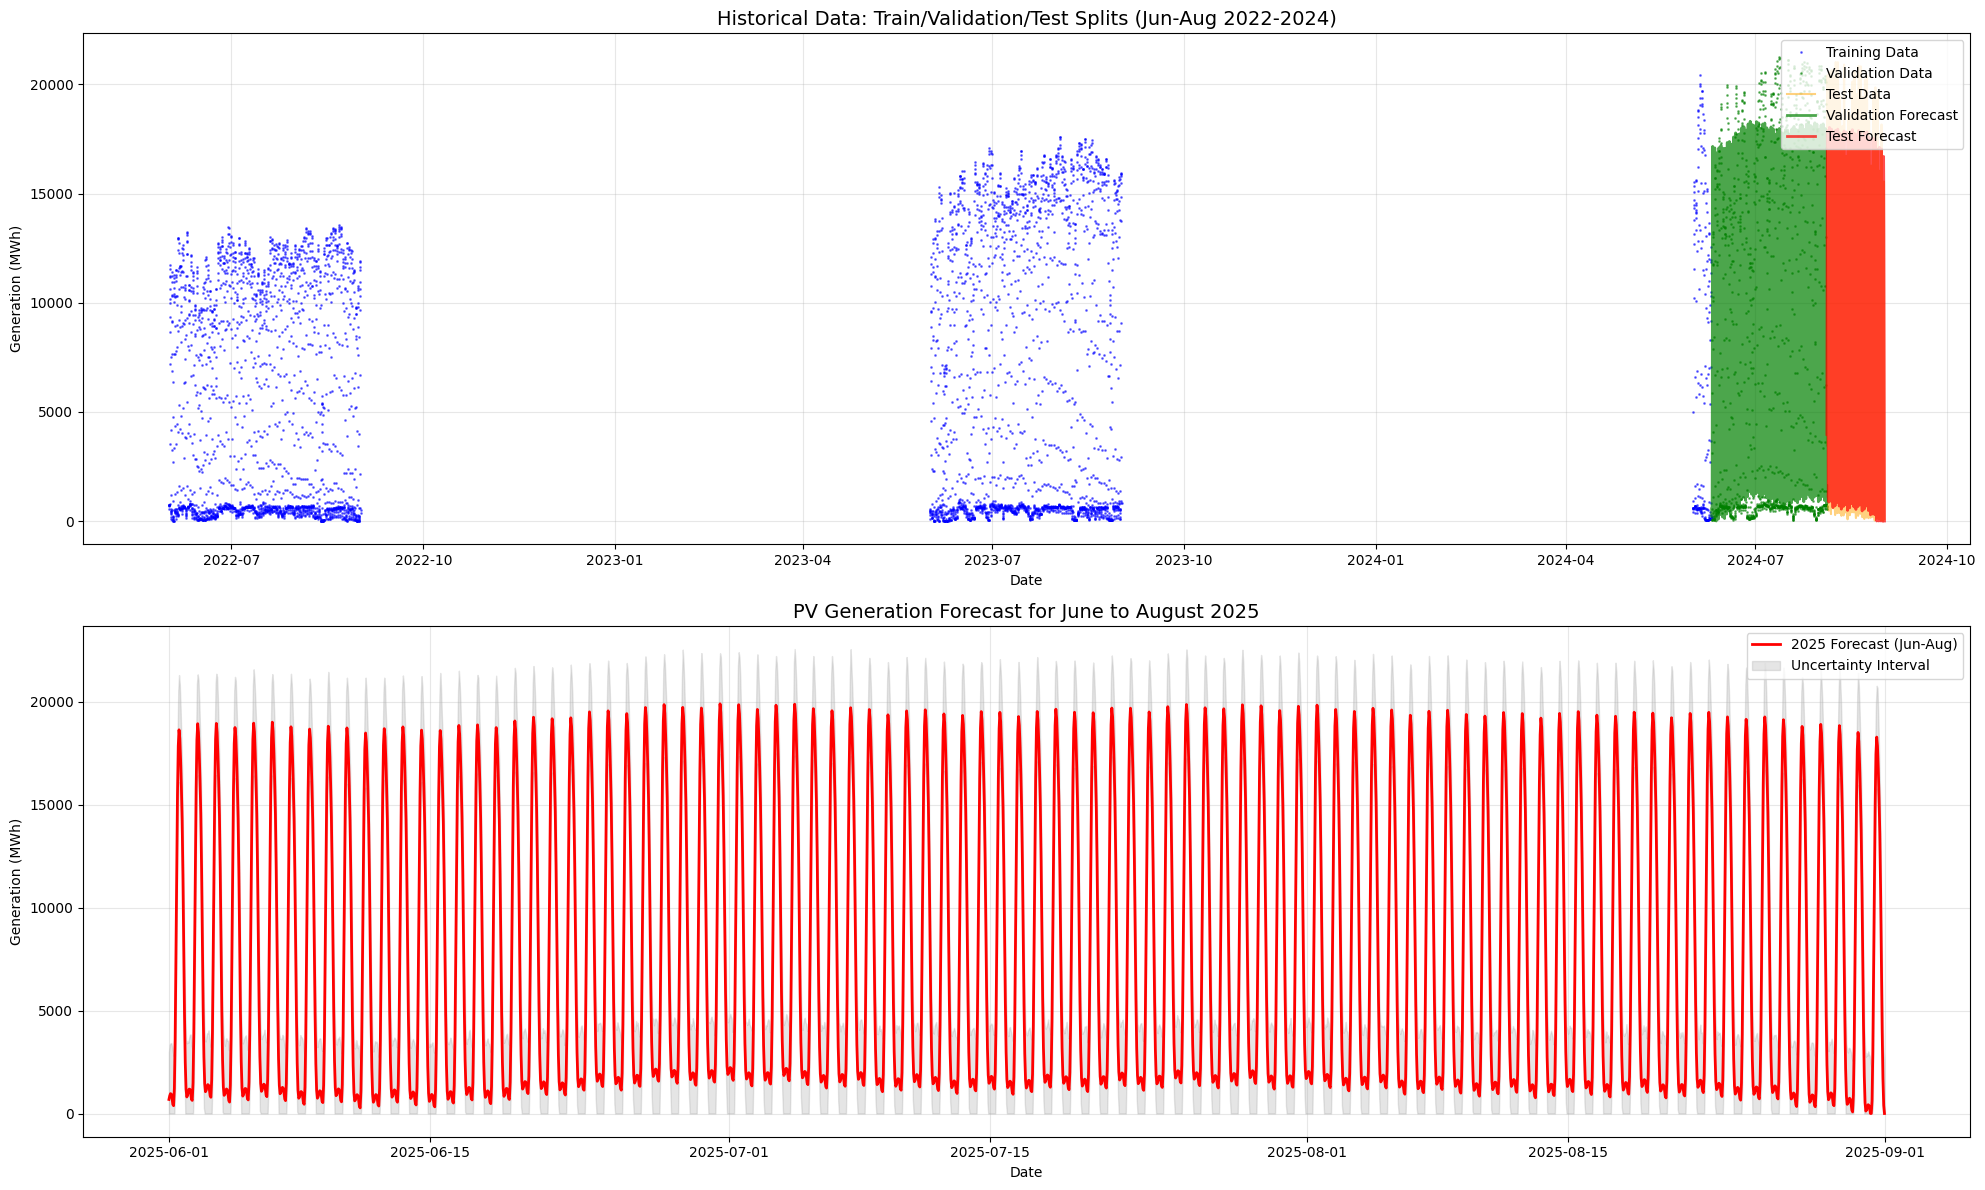

In [13]:
# Visualize train/val/test splits and model performance
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Historical data with splits (Jun-Aug 2022-2024)
ax1 = axes[0]
ax1.plot(train_df['ds'], train_df['y'], 'b.', label='Training Data', alpha=0.5, markersize=2)
ax1.plot(val_df['ds'], val_df['y'], 'g.', label='Validation Data', alpha=0.5, markersize=2)
ax1.plot(test_df['ds'], test_df['y'], 'orange', label='Test Data', alpha=0.5, markersize=2)

# Add predictions on validation and test sets
ax1.plot(val_forecast['ds'], val_forecast['yhat'], 'g-', label='Validation Forecast', linewidth=2, alpha=0.7)
ax1.plot(test_forecast['ds'], test_forecast['yhat'], 'r-', label='Test Forecast', linewidth=2, alpha=0.7)

ax1.set_title('Historical Data: Train/Validation/Test Splits (Jun-Aug 2022-2024)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Generation (MWh)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: 2025 Forecast (Jun-Aug)
ax2 = axes[1]
ax2.plot(forecast_2025['ds'], forecast_2025['yhat'], 'r-', label='2025 Forecast (Jun-Aug)', linewidth=2)
ax2.fill_between(forecast_2025['ds'], 
                 forecast_2025['yhat_lower'], 
                 forecast_2025['yhat_upper'], 
                 color='gray', 
                 alpha=0.2, 
                 label='Uncertainty Interval')

ax2.set_title('PV Generation Forecast for June to August 2025', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Generation (MWh)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


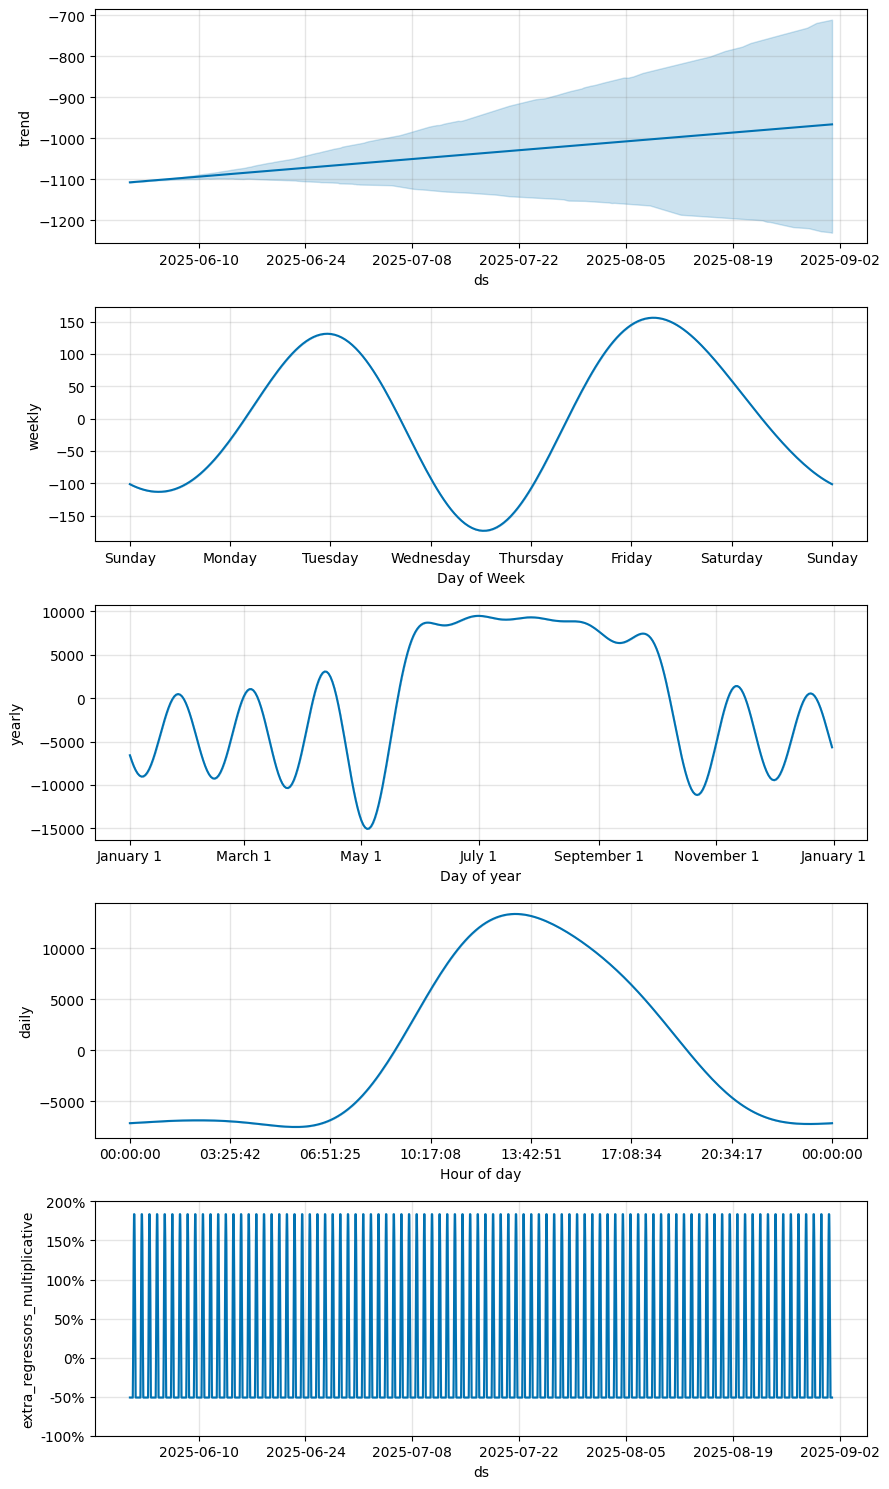

In [14]:
# Show seasonal components
fig = model.plot_components(forecast_2025)
plt.tight_layout()
plt.show()

In [15]:
# Export 2025 forecast (Jun-Aug) to CSV
forecast_export = forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_export['timestamp'] = forecast_export['ds'].dt.strftime('%Y-%m-%d %H:%M:%S')
forecast_export = forecast_export[['timestamp', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={
    'timestamp': 'Timestamp',
    'yhat': 'Forecast_Generation_MWh',
    'yhat_lower': 'Forecast_Lower_Bound_MWh',
    'yhat_upper': 'Forecast_Upper_Bound_MWh'
})

output_file = 'pv_forecast_2025_jun_aug_hourly.csv'
forecast_export.to_csv(output_file, index=False)
print(f"2025 forecast (June to August) exported to: {output_file}")
print(f"\nSummary statistics of 2025 Jun-Aug forecast:")
print(forecast_export.describe())


2025 forecast (June to August) exported to: pv_forecast_2025_jun_aug_hourly.csv

Summary statistics of 2025 Jun-Aug forecast:
       Forecast_Generation_MWh  Forecast_Lower_Bound_MWh  \
count              2208.000000               2208.000000   
mean               7898.695423               5835.186260   
std                6968.829491               6514.668125   
min                   0.000000                  0.000000   
25%                1534.074699                  0.000000   
50%                4664.994466               2120.648287   
75%               15343.269245              12793.317435   
max               19891.444302              17480.890998   

       Forecast_Upper_Bound_MWh  
count               2208.000000  
mean               10443.989026  
std                 6974.118307  
min                 2278.258632  
25%                 4075.770932  
50%                 7196.108101  
75%                17864.921897  
max                22551.074568  


In [16]:
# Load actual 2025 data for comparison
df_2025 = pd.read_csv("../Gen_data/actual_PV_2025.csv")
df_2025

,datetime,Area,Production Type,Generation (MWh)
0,2025-01-01 00:00:00,BZN|ES,Solar,4.000000
1,2025-01-01 01:00:00,BZN|ES,Solar,4.000000
2,2025-01-01 02:00:00,BZN|ES,Solar,4.000000
3,2025-01-01 03:00:00,BZN|ES,Solar,4.000000
4,2025-01-01 04:00:00,BZN|ES,Solar,4.000000
...,...,...,...,...
7047,2025-10-21 16:00:00,BZN|ES,Solar,11324.000000
7048,2025-10-21 17:00:00,BZN|ES,Solar,8866.000000
7049,2025-10-21 18:00:00,BZN|ES,Solar,4370.000000
7050,2025-10-21 19:00:00,BZN|ES,Solar,688.000000


In [17]:
# Process 2025 data similar to training data
# The datetime column should already be in the correct format
df_2025['ds'] = pd.to_datetime(df_2025['datetime'])
df_2025['y'] = df_2025['Generation (MWh)']
df_2025 = df_2025[['ds', 'y']].sort_values('ds')

# Filter for June to August 2025 only
df_2025['month'] = df_2025['ds'].dt.month
df_2025 = df_2025[(df_2025['month'] >= 6) & (df_2025['month'] <= 8)].copy()
df_2025 = df_2025[['ds', 'y']]  # Keep only required columns

print(f"2025 actual data loaded (June to August):")
print(f"  Period: {df_2025['ds'].min()} to {df_2025['ds'].max()}")
print(f"  Total records: {len(df_2025)}")
print(f"  Data range: {df_2025['y'].min():.2f} to {df_2025['y'].max():.2f} MWh")

# Merge forecast with actual 2025 data (both are hourly)
comparison = pd.merge(
    forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
    df_2025[['ds', 'y']], 
    on='ds', 
    how='inner'
)

print(f"\nMatched records: {len(comparison)}")

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

# Calculate MAPE excluding very small values
threshold = 10  # MWh
significant_mask = comparison['y'] >= threshold
if significant_mask.sum() > 0:
    mape = np.mean(np.abs((comparison['y'][significant_mask] - comparison['yhat'][significant_mask]) / comparison['y'][significant_mask])) * 100
else:
    mape = np.nan

print(f"\n2025 Forecast Performance Metrics (Jun-Aug):")
print("=" * 50)
print(f"MAE:  {mae:.2f} MWh")
print(f"RMSE: {rmse:.2f} MWh")
if not np.isnan(mape):
    print(f"MAPE (generation >= {threshold} MWh): {mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show data ranges
print(f"\nData ranges:")
print(f"  Actual values: {comparison['y'].min():.2f} to {comparison['y'].max():.2f} MWh")
print(f"  Forecasted values: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MWh")


2025 actual data loaded (June to August):
  Period: 2025-06-01 00:00:00 to 2025-08-31 23:00:00
  Total records: 2208
  Data range: 7.00 to 23999.00 MWh

Matched records: 2208

2025 Forecast Performance Metrics (Jun-Aug):
MAE:  2007.14 MWh
RMSE: 2700.91 MWh
MAPE (generation >= 10 MWh): 133.30%

Data ranges:
  Actual values: 7.00 to 23999.00 MWh
  Forecasted values: 0.00 to 19891.44 MWh


In [18]:
# Check for zero values in actual data
zero_counts = (comparison['y'] == 0).sum()
print(f"Number of zero values in actual data: {zero_counts}")

# Calculate metrics with handling for zero values
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

# Modified MAPE calculation excluding zero values
non_zero_mask = comparison['y'] != 0
mape = np.mean(np.abs((comparison['y'][non_zero_mask] - comparison['yhat'][non_zero_mask]) / comparison['y'][non_zero_mask])) * 100

print(f"\nMetrics (excluding zero values for MAPE):")
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} MW")

# Show min/max values
print(f"\nData ranges:")
print(f"Actual values range: {comparison['y'].min():.2f} to {comparison['y'].max():.2f} MW")
print(f"Forecasted values range: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MW")

Number of zero values in actual data: 0

Metrics (excluding zero values for MAPE):
Mean Absolute Error (MAE): 2007.14 MW
Mean Absolute Percentage Error (MAPE): 135.39%
Root Mean Square Error (RMSE): 2700.91 MW

Data ranges:
Actual values range: 7.00 to 23999.00 MW
Forecasted values range: 0.00 to 19891.44 MW


In [19]:
# Add hour of day for filtering daylight hours
comparison['hour'] = comparison['ds'].dt.hour

# Filter for daylight hours (e.g., between 6 AM and 8 PM)
daylight_mask = (comparison['hour'] >= 6) & (comparison['hour'] <= 20)
daylight_data = comparison[daylight_mask]

# Calculate installed capacity (using 95th percentile of actual values as proxy)
installed_capacity = comparison['y'].quantile(0.95)

# Calculate metrics for daylight hours only
daylight_metrics = {
    'MAE (Daylight)': mean_absolute_error(daylight_data['y'], daylight_data['yhat']),
    'RMSE (Daylight)': np.sqrt(mean_squared_error(daylight_data['y'], daylight_data['yhat'])),
    'nMAE': mean_absolute_error(daylight_data['y'], daylight_data['yhat']) / installed_capacity * 100,
    'nRMSE': np.sqrt(mean_squared_error(daylight_data['y'], daylight_data['yhat'])) / installed_capacity * 100
}

# Calculate skill score using persistence model (previous day as forecast)
persistence_forecast = daylight_data['y'].shift(96*4)  # Shift by 1 day (96 15-min intervals)
persistence_mse = mean_squared_error(daylight_data['y'].iloc[96*4:], persistence_forecast.iloc[96*4:])
model_mse = mean_squared_error(daylight_data['y'], daylight_data['yhat'])
skill_score = (1 - model_mse/persistence_mse) * 100

print("Alternative Metrics (Daylight Hours Only):")
print("=======================================")
print(f"Installed Capacity (95th percentile): {installed_capacity:.2f} MW")
print(f"MAE (Daylight): {daylight_metrics['MAE (Daylight)']:.2f} MW")
print(f"RMSE (Daylight): {daylight_metrics['RMSE (Daylight)']:.2f} MW")
print(f"Normalized MAE: {daylight_metrics['nMAE']:.2f}% of installed capacity")
print(f"Normalized RMSE: {daylight_metrics['nRMSE']:.2f}% of installed capacity")
print(f"Forecast Skill Score: {skill_score:.2f}% improvement over persistence model")

Alternative Metrics (Daylight Hours Only):
Installed Capacity (95th percentile): 21443.00 MW
MAE (Daylight): 2659.15 MW
RMSE (Daylight): 3324.97 MW
Normalized MAE: 12.40% of installed capacity
Normalized RMSE: 15.51% of installed capacity
Forecast Skill Score: 93.14% improvement over persistence model


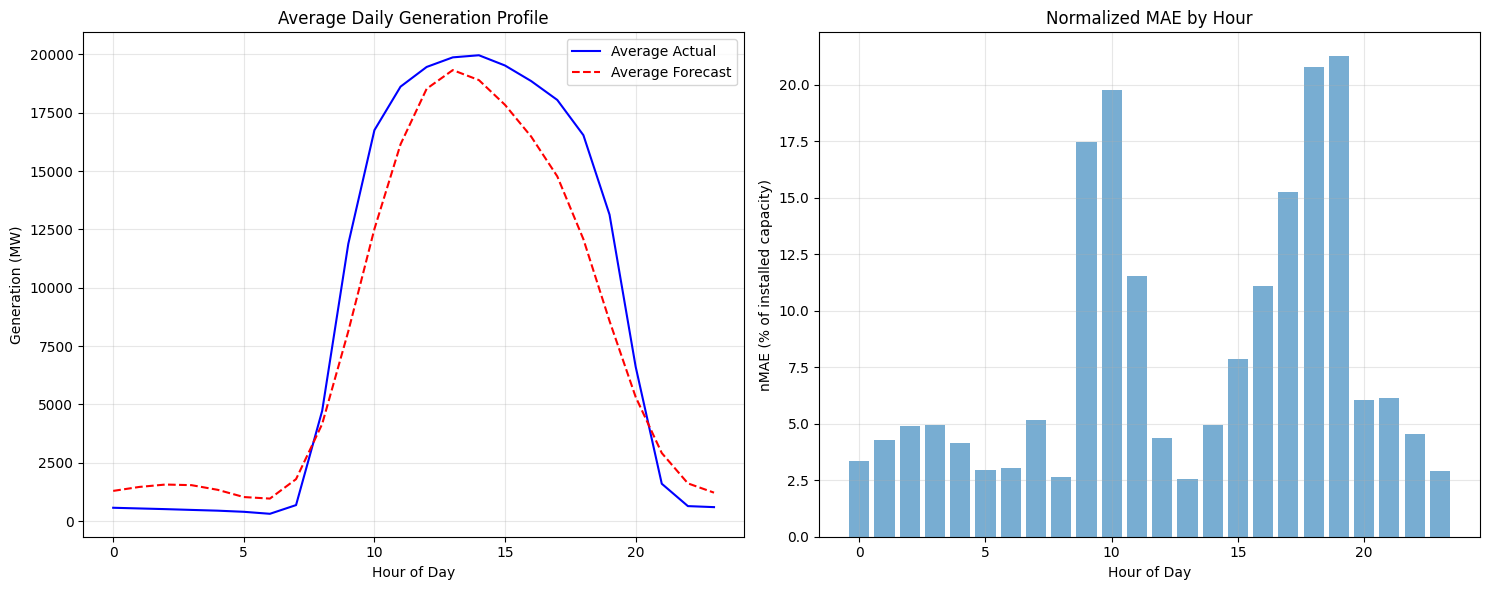

In [20]:
# Create hourly averages for error analysis
hourly_metrics = comparison.groupby('hour').agg({
    'y': 'mean',
    'yhat': 'mean'
}).reset_index()

hourly_metrics['mae'] = abs(hourly_metrics['y'] - hourly_metrics['yhat'])
hourly_metrics['nmae'] = hourly_metrics['mae'] / installed_capacity * 100

# Plot hourly performance
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(hourly_metrics['hour'], hourly_metrics['y'], 'b-', label='Average Actual')
plt.plot(hourly_metrics['hour'], hourly_metrics['yhat'], 'r--', label='Average Forecast')
plt.title('Average Daily Generation Profile')
plt.xlabel('Hour of Day')
plt.ylabel('Generation (MW)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(hourly_metrics['hour'], hourly_metrics['nmae'], alpha=0.6)
plt.title('Normalized MAE by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('nMAE (% of installed capacity)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

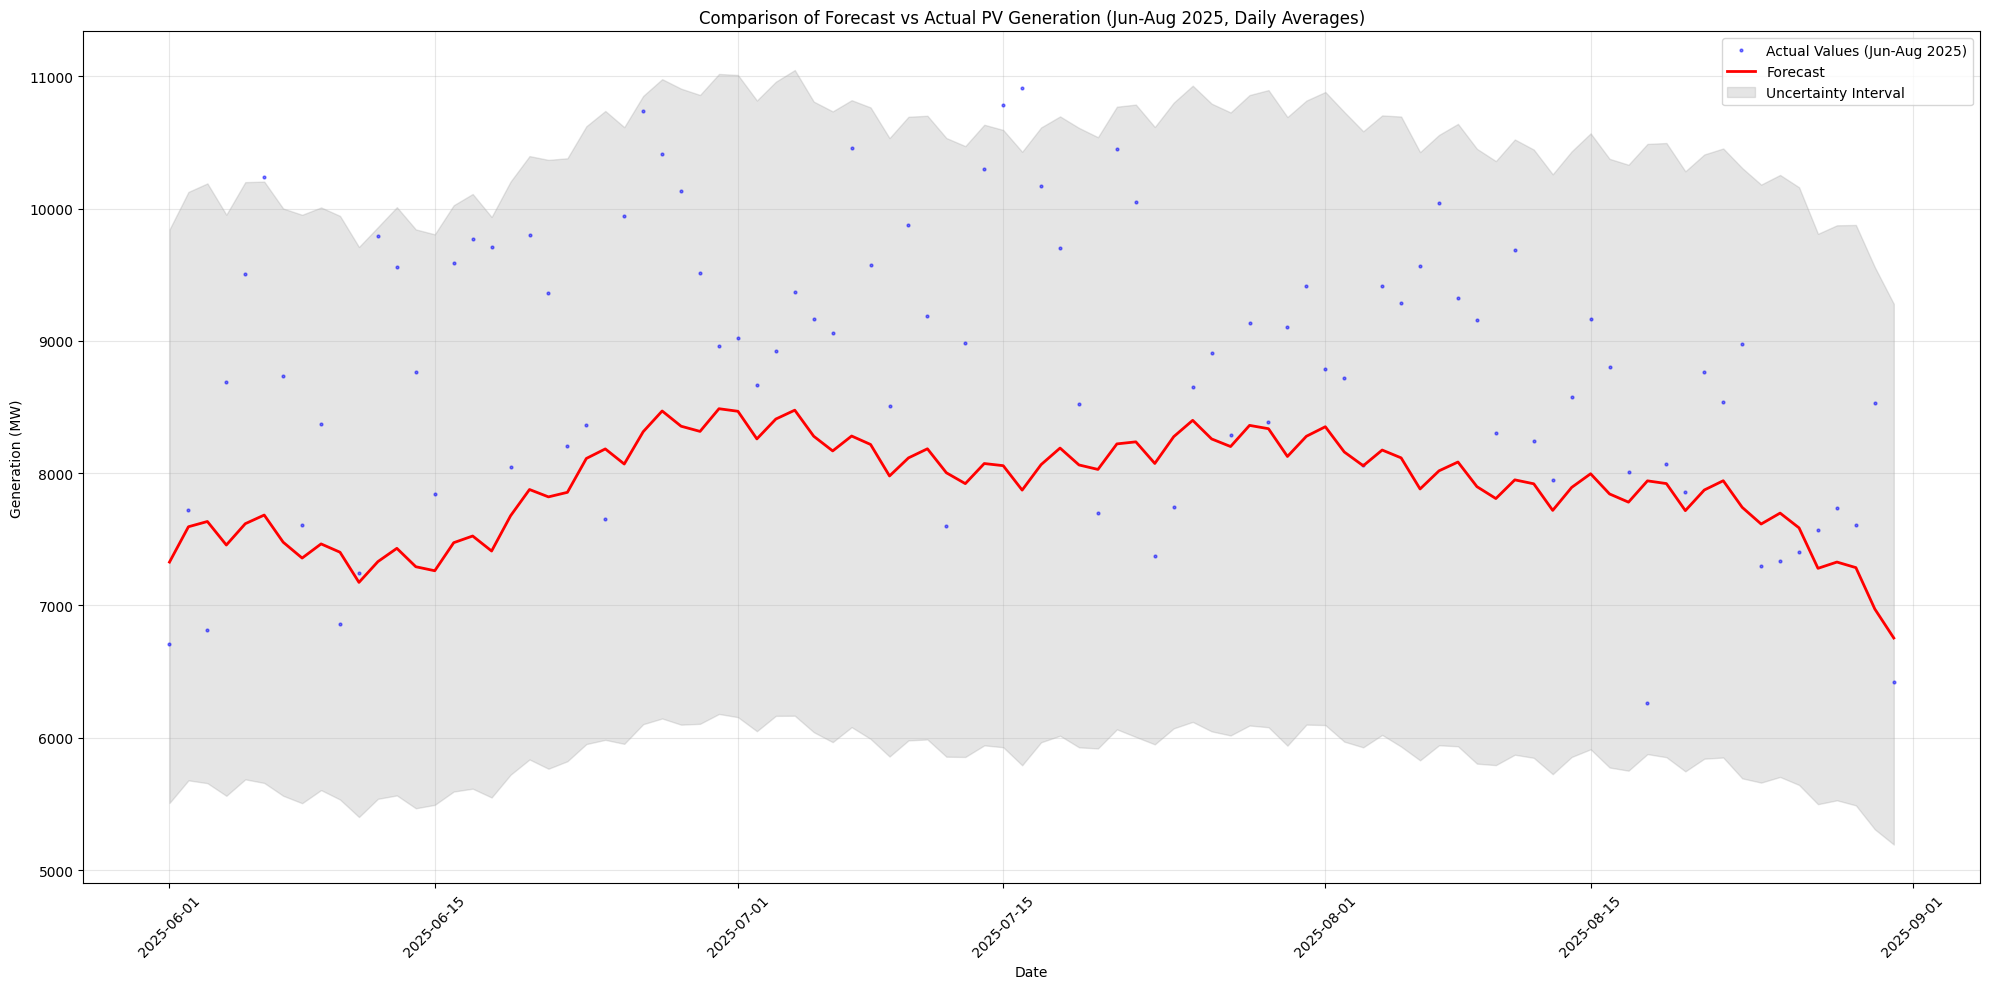


Monthly Performance Metrics (Jun-Aug 2025):
June 2025:
  Average Actual: 8821.97 MW
  Average Forecast: 7715.69 MW
  MAE: 1106.28 MW
  MAPE: 12.54%
---------------------------
July 2025:
  Average Actual: 9161.43 MW
  Average Forecast: 8190.03 MW
  MAE: 971.40 MW
  MAPE: 10.60%
---------------------------
August 2025:
  Average Actual: 8370.69 MW
  Average Forecast: 7784.46 MW
  MAE: 586.23 MW
  MAPE: 7.00%
---------------------------


C:\Users\Archer\AppData\Local\Temp\ipykernel_38968\4038731292.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = comparison.set_index('ds').resample('M').agg({


In [21]:
# Plot comparison between forecast and actual values (Jun-Aug 2025)
plt.figure(figsize=(20, 10))

# Create daily averages for better visualization
daily_comparison = comparison.set_index('ds').resample('D').mean().reset_index()

# Plot daily averages
plt.plot(daily_comparison['ds'], daily_comparison['y'], 'b.', label='Actual Values (Jun-Aug 2025)', alpha=0.5, markersize=4)
plt.plot(daily_comparison['ds'], daily_comparison['yhat'], 'r-', label='Forecast', linewidth=2)

# Plot uncertainty intervals
plt.fill_between(daily_comparison['ds'], 
                daily_comparison['yhat_lower'], 
                daily_comparison['yhat_upper'], 
                color='gray', 
                alpha=0.2, 
                label='Uncertainty Interval')

plt.title("Comparison of Forecast vs Actual PV Generation (Jun-Aug 2025, Daily Averages)")
plt.xlabel("Date")
plt.ylabel("Generation (MW)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Add monthly statistics
monthly_stats = comparison.set_index('ds').resample('M').agg({
    'y': 'mean',
    'yhat': 'mean'
}).reset_index()

monthly_stats['mae'] = abs(monthly_stats['y'] - monthly_stats['yhat'])
# Calculate MAPE only for non-zero values
monthly_stats['mape'] = np.where(
    monthly_stats['y'] > 0,
    abs((monthly_stats['y'] - monthly_stats['yhat']) / monthly_stats['y']) * 100,
    np.nan
)

print("\nMonthly Performance Metrics (Jun-Aug 2025):")
print("=" * 50)
for _, row in monthly_stats.iterrows():
    print(f"{row['ds'].strftime('%B %Y')}:")
    print(f"  Average Actual: {row['y']:.2f} MW")
    print(f"  Average Forecast: {row['yhat']:.2f} MW")
    print(f"  MAE: {row['mae']:.2f} MW")
    if np.isnan(row['mape']):
        print("  MAPE: N/A (zero values in actual data)")
    else:
        print(f"  MAPE: {row['mape']:.2f}%")
    print("---------------------------")


In [22]:
# Export comparison data to CSV
export_data = comparison.copy()

# Add the hour information (if not already present)
if 'hour' not in export_data.columns:
    export_data['hour'] = export_data['ds'].dt.hour

# Convert datetime to string for better CSV readability
export_data['timestamp'] = export_data['ds'].dt.strftime('%Y-%m-%d %H:%M')

# Select and rename columns for clarity
export_data = export_data[[
    'timestamp', 
    'hour',
    'y', 
    'yhat', 
    'yhat_lower', 
    'yhat_upper'
]].rename(columns={
    'timestamp': 'Timestamp',
    'hour': 'Hour',
    'y': 'Actual_Generation_MWh',
    'yhat': 'Forecast_Generation_MWh',
    'yhat_lower': 'Forecast_Lower_Bound_MWh',
    'yhat_upper': 'Forecast_Upper_Bound_MWh'
})

# Export to CSV
output_path = 'pv_forecast_comparison_2025.csv'
export_data.to_csv(output_path, index=False)
print(f"Data exported to: {output_path}")
print(f"Total records exported: {len(export_data)}")
print("\nFirst few rows of exported data:")
print(export_data.head(24).to_string())

Data exported to: pv_forecast_comparison_2025.csv
Total records exported: 2208

First few rows of exported data:
           Timestamp  Hour  Actual_Generation_MWh  Forecast_Generation_MWh  Forecast_Lower_Bound_MWh  Forecast_Upper_Bound_MWh
0   2025-06-01 00:00     0                  654.0               682.906885                  0.000000               2985.339758
1   2025-06-01 01:00     1                  588.0               856.697185                  0.000000               3340.793758
2   2025-06-01 02:00     2                  563.0               963.387092                  0.000000               3406.538234
3   2025-06-01 03:00     3                  554.0               941.617460                  0.000000               3419.373842
4   2025-06-01 04:00     4                  424.0               747.124948                  0.000000               3253.168138
5   2025-06-01 05:00     5                  298.0               441.519130                  0.000000               2997.15487